In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from scipy.stats import norm

# Some useful stuff

In [2]:
def get_bins_and_plot_dist(ax, dist, title, color, n_bins, normed=False):
    mean = np.mean(dist)
    std = np.std(dist)
    ax.set_title("{:10}, mean = {:.3f}, std = {:.3f}".format(title, mean, std))
    values, bins, _ = ax.hist(dist, color=color, bins=n_bins, normed=normed)
    return bins, values
    
def get_theoretical_values(F, bins, n):
    a = np.zeros(len(bins) - 1)
    for i in range(1, len(bins)):
        a[i-1] = F(bins[i]) - F(bins[i-1])
    return a * n

def join_bins(*arrays, k=5):
    lengths = np.array(list(map(len, arrays)))
    
    assert np.all(lengths > 0)
    assert len(np.unique(lengths)) == 1
    
    result = [[a[0]] for a in arrays]
    i = 1
    while i < len(arrays[0]):
        if np.any(np.array([b[-1] < k for b in result])) or np.any(np.array([a[i] < k for a in arrays])):
            for j in range(len(arrays)):
                result[j][-1] += arrays[j][i]
        else:
            for j in range(len(arrays)):
                result[j].append(arrays[j][i])
        i += 1
    return tuple(result)

# Creating generated and theoretical distributions

In [3]:
size = 10000
n_bins = 20

distributions = {
    'uniform': {
        'bins': None,
        'generated_values': None,
        'theoretical_values': None,
        'F': lambda x: x
    },
    'normal': {
        'bins': None,
        'generated_values': None,
        'theoretical_values': None,
        'F': lambda x: norm.cdf(x)
    },
    'exponetial': {
        'bins': None,
        'generated_values': None,
        'theoretical_values': None,
        'F': lambda x: 1. - np.exp(-1. * x)
    }
}

## Generating distributions randomly

In [4]:
uniform = np.random.uniform(size=size)
normal = np.random.normal(size=size)
exponential = np.random.exponential(size=size)

### Ploting results

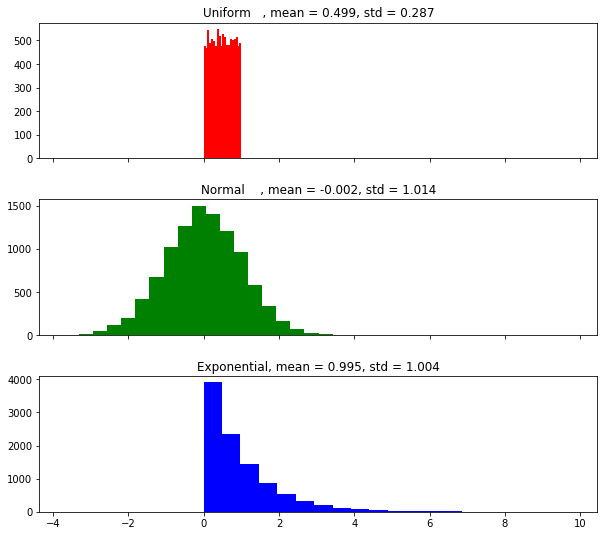

In [5]:
f, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 9), sharex=True)

distributions['uniform']['bins'], distributions['uniform']['generated_values'] = \
    get_bins_and_plot_dist(ax1, uniform, "Uniform", 'r', n_bins=n_bins)
distributions['normal']['bins'], distributions['normal']['generated_values'] = \
    get_bins_and_plot_dist(ax2, normal, "Normal", 'g', n_bins=n_bins)
distributions['exponetial']['bins'], distributions['exponetial']['generated_values'] = \
    get_bins_and_plot_dist(ax3, exponential, "Exponential", 'b', n_bins=n_bins)

f.subplots_adjust(hspace=0.3)
plt.show()

## Calculating theoretical frequencies 

In [6]:
for dist_name in distributions.keys():
    distributions[dist_name]['theoretical_values'] = get_theoretical_values(
        distributions[dist_name]['F'],
        distributions[dist_name]['bins'],
        size
    )

# Test $ \chi^2 $

## Join bins

In [7]:
min_points = 5

for dist_name in distributions.keys():
    distributions[dist_name]['generated_values'], distributions[dist_name]['theoretical_values'] = join_bins(
        distributions[dist_name]['generated_values'],
        distributions[dist_name]['theoretical_values'],
        k=min_points
    )

In [8]:
for dist_name, dist in distributions.items():
    r = chisquare(
        np.array(dist['generated_values'], dtype=int),
        f_exp=np.array(dist['theoretical_values'], dtype=int)
    )
    print("{:10}: {}".format(dist_name, r))

uniform   : Power_divergenceResult(statistic=20.276553106212425, pvalue=0.37811255259596299)
exponetial: Power_divergenceResult(statistic=5.9614168418775852, pvalue=0.94754588860923461)
normal    : Power_divergenceResult(statistic=20.068099222584792, pvalue=0.27076094152012709)
